In [51]:
from abc import ABC, abstractmethod
import math
import numpy as np
import torch
from torch import utils
from torch import nn
from torch import optim
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToPILImage

In [2]:
data_dir = '/Users/armandli/data/'

In [3]:
model_dir = '/Users/armandli/journal/models/'

In [4]:
use_cuda = torch.cuda.is_available()
use_mps = torch.backends.mps.is_built()
if use_cuda:
    device = torch.device('cuda')
elif use_mps:
    device = torch.device('cpu')
else:
    device = torch.device('cpu')
cpu = torch.device('cpu')

In [5]:
default_batch_size = 256
loader_args = {'batch_size' : default_batch_size, 'shuffle' : True}
score_args = {'batch_size' : default_batch_size, 'shuffle' : False}
if use_cuda:
    loader_args.update({'pin_memory' : True})
    score_args.update({'pin_memory' : True})

data

In [5]:
trainset = datasets.MNIST(root=data_dir, train=True, transform=transforms.ToTensor(), download=True)
evalset  = datasets.MNIST(root=data_dir, train=False, transform=transforms.ToTensor(), download=True)

In [6]:
trainset = datasets.CIFAR10(root=data_dir, train=True, transform=transforms.ToTensor(), download=True)
evalset = datasets.CIFAR10(root=data_dir, train=True, transform=transforms.ToTensor(), download=True)

Files already downloaded and verified
Files already downloaded and verified


In [7]:
len(trainset), len(evalset)

(50000, 50000)

In [8]:
train_loader = utils.data.DataLoader(dataset=trainset, **loader_args)
eval_loader = utils.data.DataLoader(dataset=evalset, **score_args)

Model

In [9]:
class Gate(nn.Module):
    def __init__(self):
        super(Gate, self).__init__()
    def forward(self, x):
        a, b = torch.chunk(x, 2, dim=1)
        return a * F.sigmoid(b)

In [10]:
class ConcatELU(nn.Module):
    def __init__(self):
        super(ConcatELU, self).__init__()
    def forward(self, x):
        #concat at channel dim
        return F.elu(torch.cat([x, -x], dim=1))

In [11]:
class WeightNormLinear2d(nn.Module):
    def __init__(self, d_in, d_out):
        super(WeightNormLinear2d, self).__init__()
        self.layer = nn.utils.parametrizations.weight_norm(nn.Linear(d_in, d_out))
        self.d_out = d_out

    def forward(self, x):
        x = x.permute(0, 2, 3, 1)
        shape = [int(d) for d in x.shape]
        x = self.layer(x.contiguous().view(shape[0]*shape[1]*shape[2], shape[3]))
        shape[-1] = self.d_out
        x = x.view(shape).permute(0, 3, 1, 2)
        return x

In [12]:
class WeightNormConv2d(nn.Module):
    def __init__(self, in_c, out_c, kernel_size, stride=1, padding=0):
        super(WeightNormConv2d, self).__init__()
        self.layer = nn.utils.parametrizations.weight_norm(nn.Conv2d(in_c, out_c, kernel_size=kernel_size, stride=stride, padding=padding))
        
    def forward(self, x):
        return self.layer(x)

In [13]:
class DownShift(nn.Module):
    def __init__(self):
        super(DownShift, self).__init__()
        #pad Left=0 Right=0 Up=1 Down=0
        self.pad = nn.ZeroPad2d((0,0,1,0))
    def forward(self, x):
        shape = x.shape
        x = x[:, :, :shape[2]-1, :]
        x = self.pad(x)
        return x

In [14]:
class RightShift(nn.Module):
    def __init__(self):
        super(RightShift, self).__init__()
        #pad Left=1 Right=0 Up=0 Down=0
        self.pad = nn.ZeroPad2d((1,0,0,0))
    def forward(self, x):
        shape = x.shape
        x = x[:, :, :, :shape[3]-1]
        x = self.pad(x)
        return x

In [15]:
class DownShiftConv2d(nn.Module):
    def __init__(self, in_c, out_c, kernel_size=(2,3), stride=(1,1), shift_down=False):
        super(DownShiftConv2d, self).__init__()
        self.layers = nn.Sequential(
            nn.ZeroPad2d((int((kernel_size[1]-1)/2),int((kernel_size[1]-1)/2),kernel_size[0]-1,0)),
            WeightNormConv2d(in_c, out_c, kernel_size, stride),
        )
        if shift_down:
            self.shift_down = DownShift()
        else:
            self.shift_down = nn.Identity()

    def forward(self, x):
        x = self.layers(x)
        x = self.shift_down(x)
        return x

In [16]:
class DownRightShiftConv2d(nn.Module):
    def __init__(self, in_c, out_c, kernel_size=(2,2), stride=(1,1), shift_right=False):
        super(DownRightShiftConv2d, self).__init__()
        self.layers = nn.Sequential(
            nn.ZeroPad2d((kernel_size[1]-1, 0, kernel_size[0]-1, 0)),
            WeightNormConv2d(in_c, out_c, kernel_size, stride),
        )
        if shift_right:
            self.shift_right = RightShift()
        else:
            self.shift_right = nn.Identity()
    
    def forward(self, x):
        x = self.layers(x)
        x = self.shift_right(x)
        return x

In [17]:
class GatedResidualLayer(nn.Module):
    def __init__(self, nc, conv, skip=0, p_dropout=0.5):
        super(GatedResidualLayer, self).__init__()
        self.layer1 = nn.Sequential(
            ConcatELU(),
            conv(2*nc, nc),
        )
        self.layer2 = nn.Sequential(
            ConcatELU(),
            nn.Dropout2d(p_dropout),
            conv(2*nc, 2*nc),
            Gate(),
        )
        if skip > 0:
            self.skip = nn.Sequential(
                ConcatELU(),
                WeightNormLinear2d(2*skip*nc, nc),
            )
        
    def forward(self, x, a=None):
        s = x
        x = self.layer1(x)
        if a is not None:
            x += self.skip(a)
        x = self.layer2(x)
        return s + x

In [18]:
class UpSample(nn.Module):
    def __init__(self, nlayers, nchannel):
        super(UpSample, self).__init__()
        self.up_stream = nn.ModuleList([
            GatedResidualLayer(nchannel, DownShiftConv2d, skip=0)
            for _ in range(nlayers)
        ])
        self.upleft_stream = nn.ModuleList([
            GatedResidualLayer(nchannel, DownRightShiftConv2d, skip=1)
            for _ in range(nlayers)
        ])
        self.nlayers = nlayers
    def forward(self, up, upleft):
        ups, uplefts = [], []
        for i in range(self.nlayers):
            up = self.up_stream[i](up)
            upleft = self.upleft_stream[i](upleft, a=up)
            ups.append(up)
            uplefts.append(upleft)
        return ups, uplefts

In [19]:
class DownSample(nn.Module):
    def __init__(self, nlayer, nchannel):
        super(DownSample, self).__init__()
        self.up_stream = nn.ModuleList([
            GatedResidualLayer(nchannel, DownShiftConv2d, skip=1)
            for _ in range(nlayer)
        ])
        self.upleft_stream = nn.ModuleList([
            GatedResidualLayer(nchannel, DownRightShiftConv2d, skip=2)
            for _ in range(nlayer)
        ])
        self.nlayer = nlayer
    
    def forward(self, up, upleft, ups, uplefts):
        for i in range(self.nlayer):
            up = self.up_stream[i](up, a=ups.pop())
            upleft = self.upleft_stream[i](upleft, a=torch.cat((up, uplefts.pop()), 1))
        return up, upleft

In [20]:
class WeightNormConvTransposed2d(nn.Module):
    def __init__(self, in_c, out_c, kernel_size, stride, output_padding=1):
        super(WeightNormConvTransposed2d, self).__init__()
        self.layer = nn.utils.parametrizations.weight_norm(nn.ConvTranspose2d(in_c, out_c, kernel_size, stride, output_padding=output_padding))
    
    def forward(self, x):
        return self.layer(x)

In [21]:
class DownShiftDeconv2d(nn.Module):
    def __init__(self, in_c, out_c, kernel_size=(2,3), stride=(2,2)):
        super(DownShiftDeconv2d, self).__init__()
        self.ks = kernel_size
        self.layer = WeightNormConvTransposed2d(in_c, out_c, kernel_size, stride, output_padding=1)
    
    def forward(self, x):
        x = self.layer(x)
        s = x.shape
        # correct the shape because TransposedConv2d would produce a few rows and columns bigger
        x = x[:, :, :(s[2]-self.ks[0]+1), int((self.ks[1]-1)/2):(s[3]-int((self.ks[1]-1)/2))]
        return x

In [22]:
class DownRightShiftDeconv2d(nn.Module):
    def __init__(self, in_c, out_c, kernel_size=(2,2), stride=(2,2)):
        super(DownRightShiftDeconv2d, self).__init__()
        self.ks = kernel_size
        self.layer = WeightNormConvTransposed2d(in_c, out_c, kernel_size, stride, output_padding=1)
    
    def forward(self, x):
        x = self.layer(x)
        s = x.shape
        # correct the shape because TransposedConv2d produces a few rows and columns bigger
        x = x[:, :, :(s[2]-self.ks[0]+1):, :(s[3]-self.ks[1]+1)]
        return x

In [23]:
class PixelCNN(nn.Module):
    def __init__(self, in_c, nresnet, nlayer, nchannel=80, nlogmix=10):
        super(PixelCNN, self).__init__()
        down_nlayer = [nresnet] + [nresnet+1 for _ in range(1, nlayer)]
        self.down_layers = nn.ModuleList([
            DownSample(down_nlayer[i], nchannel) for i in range(nlayer)
        ])
        self.up_layers = nn.ModuleList([
            UpSample(nresnet, nchannel) for _ in range(nlayer)
        ])
        self.downsize_up_stream = nn.ModuleList([
            DownShiftConv2d(nchannel, nchannel, stride=(2,2)) for _ in range((nlayer-1))
        ])
        self.downsize_upleft_stream = nn.ModuleList([
            DownRightShiftConv2d(nchannel, nchannel, stride=(2,2)) for _ in range(nlayer-1)
        ])
        self.upsize_up_stream = nn.ModuleList([
            DownShiftDeconv2d(nchannel, nchannel, stride=(2,2)) for _ in range(nlayer-1)
        ])
        self.upsize_upleft_stream = nn.ModuleList([
            DownRightShiftDeconv2d(nchannel, nchannel, stride=(2,2)) for _ in range(nlayer-1)
        ])
        self.up_init = DownShiftConv2d(in_c+1, nchannel, kernel_size=(2,3), shift_down=True)
        self.upleft_init = nn.ModuleList([
            DownShiftConv2d(in_c+1, nchannel, kernel_size=(1,3), shift_down=True),
            DownRightShiftConv2d(in_c+1, nchannel, kernel_size=(2,1), shift_right=True),
        ])
        self.out_layer = nn.Sequential(
            nn.ELU(),
            WeightNormLinear2d(nchannel, 10*nlogmix),
        )
        self.nlayer = nlayer
    
    def forward(self, x, device):
        shape = x.shape
        padding = torch.ones(shape[0], 1, shape[2], shape[3], device=device, requires_grad=False)
        x = torch.cat((x, padding), 1)
        
        # UP PASS
        ups = [self.up_init(x)]
        uplefts = [self.upleft_init[0](x) + self.upleft_init[1](x)]
        for i in range(self.nlayer):
            up_out, upleft_out = self.up_layers[i](ups[-1], uplefts[-1])
            ups.extend(up_out)
            uplefts.extend(upleft_out)
            if i < self.nlayer-1:
                ups.append(self.downsize_up_stream[i](ups[-1]))
                uplefts.append(self.downsize_upleft_stream[i](uplefts[-1]))

        # DOWN PASS
        up = ups.pop()
        upleft = uplefts.pop()
        for i in range(self.nlayer):
            up, upleft = self.down_layers[i](up, upleft, ups, uplefts)
            if i < self.nlayer-1:
                up = self.upsize_up_stream[i](up)
                upleft = self.upsize_upleft_stream[i](upleft)
        
        x = self.out_layer(upleft)
        return x

    def sample(self, batch_sz, img_shape, device):
        x = torch.zeros(batch_sz, img_shape[0], img_shape[1], img_shape[2]).to(device)
        shape = x.shape
        padding = torch.ones(shape[0], 1, shape[2], shape[3], device=device, requires_grad=False)
        x = torch.cat((x, padding), 1)
        
        # UP PASS
        ups = [self.up_init(x)]
        uplefts = [self.upleft_init[0](x) + self.upleft_init[1](x)]
        for i in range(self.nlayer):
            up_out, upleft_out = self.up_layers[i](ups[-1], uplefts[-1])
            ups.extend(up_out)
            uplefts.extend(upleft_out)
            if i < self.nlayer-1:
                ups.append(self.downsize_up_stream[i](ups[-1]))
                uplefts.append(self.downsize_upleft_stream[i](uplefts[-1]))

        # DOWN PASS
        up = ups.pop()
        upleft = uplefts.pop()
        for i in range(self.nlayer):
            up, upleft = self.down_layers[i](up, upleft, ups, uplefts)
            if i < self.nlayer-1:
                up = self.upsize_up_stream[i](up)
                upleft = self.upsize_upleft_stream[i](upleft)
        
        x = self.out_layer(upleft)
        return x

test

In [27]:
model = PixelCNN(in_c=3, nresnset=1, nlayer=2)

In [28]:
input = trainset[0][0].unsqueeze(0)
input.shape

torch.Size([1, 3, 32, 32])

In [29]:
out = model(input, device)

In [30]:
out

tensor([[[[-0.0719, -0.0721, -0.0923,  ..., -0.1098, -0.1023, -0.0992],
          [-0.1239, -0.0966, -0.1256,  ..., -0.1224, -0.1350, -0.1146],
          [-0.1110, -0.0945, -0.1187,  ..., -0.1443, -0.1319, -0.1244],
          ...,
          [-0.1250, -0.0978, -0.1688,  ..., -0.1535, -0.1632, -0.1230],
          [-0.1215, -0.1003, -0.1636,  ..., -0.1354, -0.1356, -0.1053],
          [-0.1224, -0.0945, -0.1713,  ..., -0.1527, -0.1680, -0.1359]],

         [[-0.0880, -0.1029, -0.1201,  ..., -0.1225, -0.1123, -0.1184],
          [-0.0989, -0.1006, -0.1398,  ..., -0.1536, -0.1479, -0.1575],
          [-0.0992, -0.1250, -0.1519,  ..., -0.1730, -0.1647, -0.1765],
          ...,
          [-0.0823, -0.1364, -0.1963,  ..., -0.1821, -0.2313, -0.1719],
          [-0.0698, -0.1350, -0.1659,  ..., -0.1934, -0.1918, -0.1936],
          [-0.0743, -0.1438, -0.1899,  ..., -0.2187, -0.2172, -0.1716]],

         [[-0.0534, -0.0046, -0.0351,  ..., -0.0116, -0.0334, -0.0114],
          [-0.0470, -0.0141, -

In [31]:
out.shape

torch.Size([1, 100, 32, 32])

training

In [24]:
def log_sum_exp(x):
    """ numerically stable log_sum_exp implementation that prevents overflow """
    # TF ordering
    axis  = len(x.size()) - 1
    m, _  = torch.max(x, dim=axis)
    m2, _ = torch.max(x, dim=axis, keepdim=True)
    return m + torch.log(torch.sum(torch.exp(x - m2), dim=axis))

In [25]:
def log_prob_from_logits(x):
    """ numerically stable log_softmax implementation that prevents overflow """
    # TF ordering
    axis = len(x.size()) - 1
    m, _ = torch.max(x, dim=axis, keepdim=True)
    return x - m - torch.log(torch.sum(torch.exp(x - m), dim=axis, keepdim=True))

In [58]:
class DiscretizedMixLogisticLoss(nn.Module):
    def __init__(self, nmix):
        super(DiscretizedMixLogisticLoss, self).__init__()
        self.nmix = nmix
    
    def log_sum_exp(self, x):
        axis = len(x.shape)-1
        m, _ = torch.max(x, dim=axis)
        n, _ = torch.max(x, dim=axis, keepdim=True)
        return m + torch.log(torch.sum(torch.exp(x-n), dim=axis))

    def log_prob_from_logits(self, x):
        axis = len(x.shape)-1
        m, _ = torch.max(x, dim=axis, keepdim=True)
        return x - m - torch.log(torch.sum(torch.exp(x-m), dim=axis, keepdim=True))
    
    def forward(self, target, prediction, device):
        nmix = self.nmix
        target = target.permute(0, 2, 3, 1)
        prediction = prediction.permute(0, 2, 3, 1)
        ts = list(target.shape)

        # unpack prediction parameters
        lp = prediction[:,:,:,:nmix]
        prediction = prediction[:,:,:,nmix:].view(ts+[nmix*3]) # 3 for mean, scale, coeff
        means = prediction[:,:,:,:,:nmix]
        log_scales = torch.clamp(prediction[:,:,:,:,nmix:nmix*2], min=-7.)
        coeffs = F.tanh(prediction[:,:,:,:,nmix*2:nmix*3])
        target = target.unsqueeze(-1) + torch.zeros(ts+[nmix], requires_grad=False).to(device)
        
        m2 = (means[:,:,:,1,:]+coeffs[:,:,:,0,:]*target[:,:,:,0,:]).view(ts[0],ts[1],ts[2],1,nmix)
        m3 = (means[:,:,:,2,:]+coeffs[:,:,:,1,:]*target[:,:,:,0,:]+coeffs[:,:,:,2,:]*target[:,:,:,1,:]).view(ts[0],ts[1],ts[2],1,nmix)
        
        centered_target = target - torch.cat((means[:,:,:,0,:].unsqueeze(3), m2, m3), dim=3)
        inv_stdv  = torch.exp(-log_scales)
        plus_in   = inv_stdv * (centered_target + 1./255.)
        cdf_plus  = F.sigmoid(plus_in)
        min_in    = inv_stdv * (centered_target - 1./255.)
        cdf_minus = F.sigmoid(min_in)

        log_cdf_plus          = plus_in - F.softplus(plus_in)
        log_one_minus_cdf_min = -F.softplus(min_in)
        cdf_delta             = cdf_plus - cdf_minus
        log_pdf_mid = (inv_stdv*centered_target) - log_scales - 2.*F.softplus(inv_stdv*centered_target)

        inner_inner_cond = (cdf_delta > 1e-5).float()
        inner_inner_out  = inner_inner_cond * torch.log(torch.clamp(cdf_delta, min=1e-12)) + (1-inner_inner_cond)*(log_pdf_mid-math.log(127.5))
        inner_cond       = (target > 0.999).float()
        inner_out        = inner_cond*log_one_minus_cdf_min + (1.-inner_cond)*inner_inner_out
        cond             = (target < -0.999).float()
        log_probs        = cond*log_cdf_plus + (1.-cond)*inner_out
        log_probs        = torch.sum(log_probs, dim=3) + self.log_prob_from_logits(lp)
        return -torch.sum(self.log_sum_exp(log_probs))

In [27]:
def discretized_mix_logistic_loss(x, l, device):
    """ log-likelihood for mixture of discretized logistics, assumes the data has been rescaled to [-1,1] interval """
    # Pytorch ordering
    x = x.permute(0, 2, 3, 1)
    l = l.permute(0, 2, 3, 1)
    xs = [int(y) for y in x.size()]
    ls = [int(y) for y in l.size()]
   
    # here and below: unpacking the params of the mixture of logistics
    nr_mix = int(ls[-1] / 10)
    #print(f"gothere10 {nr_mix} {ls[-1]} {l.size()} {l.shape}")
    logit_probs = l[:, :, :, :nr_mix]
    l = l[:, :, :, nr_mix:].contiguous().view(xs + [nr_mix * 3]) # 3 for mean, scale, coef
    #print(f"gothere11 {l.shape}")
    means = l[:, :, :, :, :nr_mix]
    # log_scales = torch.max(l[:, :, :, :, nr_mix:2 * nr_mix], -7.)
    log_scales = torch.clamp(l[:, :, :, :, nr_mix:2 * nr_mix], min=-7.)
   
    coeffs = F.tanh(l[:, :, :, :, 2 * nr_mix:3 * nr_mix])
    # here and below: getting the means and adjusting them based on preceding
    # sub-pixels
    x = x.contiguous()
    x = x.unsqueeze(-1) + Variable(torch.zeros(xs + [nr_mix]).to(device), requires_grad=False)
    #print(f"gothere12 new x {x.shape}")
    m2 = (means[:, :, :, 1, :] + 
          coeffs[:, :, :, 0, :] * x[:, :, :, 0, :]
    ).view(xs[0], xs[1], xs[2], 1, nr_mix)

    m3 = (means[:, :, :, 2, :] + 
          coeffs[:, :, :, 1, :] * x[:, :, :, 0, :] + 
          coeffs[:, :, :, 2, :] * x[:, :, :, 1, :]
    ).view(xs[0], xs[1], xs[2], 1, nr_mix)

    means = torch.cat((means[:, :, :, 0, :].unsqueeze(3), m2, m3), dim=3)
    centered_x = x - means
    inv_stdv = torch.exp(-log_scales)
    plus_in = inv_stdv * (centered_x + 1. / 255.)
    cdf_plus = F.sigmoid(plus_in)
    min_in = inv_stdv * (centered_x - 1. / 255.)
    cdf_min = F.sigmoid(min_in)
    # log probability for edge case of 0 (before scaling)
    log_cdf_plus = plus_in - F.softplus(plus_in)
    # log probability for edge case of 255 (before scaling)
    log_one_minus_cdf_min = -F.softplus(min_in)
    cdf_delta = cdf_plus - cdf_min  # probability for all other cases
    mid_in = inv_stdv * centered_x
    # log probability in the center of the bin, to be used in extreme cases
    # (not actually used in our code)
    log_pdf_mid = mid_in - log_scales - 2. * F.softplus(mid_in)

    # now select the right output: left edge case, right edge case, normal
    # case, extremely low prob case (doesn't actually happen for us)

    # this is what we are really doing, but using the robust version below for extreme cases in other applications and to avoid NaN issue with tf.select()
    # log_probs = tf.select(x < -0.999, log_cdf_plus, tf.select(x > 0.999, log_one_minus_cdf_min, tf.log(cdf_delta)))

    # robust version, that still works if probabilities are below 1e-5 (which never happens in our code)
    # tensorflow backpropagates through tf.select() by multiplying with zero instead of selecting: this requires use to use some ugly tricks to avoid potential NaNs
    # the 1e-12 in tf.maximum(cdf_delta, 1e-12) is never actually used as output, it's purely there to get around the tf.select() gradient issue
    # if the probability on a sub-pixel is below 1e-5, we use an approximation
    # based on the assumption that the log-density is constant in the bin of
    # the observed sub-pixel value

    inner_inner_cond = (cdf_delta > 1e-5).float()
    inner_inner_out  = inner_inner_cond * torch.log(torch.clamp(cdf_delta, min=1e-12)) + (1. - inner_inner_cond) * (log_pdf_mid - np.log(127.5))
    inner_cond       = (x > 0.999).float()
    inner_out        = inner_cond * log_one_minus_cdf_min + (1. - inner_cond) * inner_inner_out
    cond             = (x < -0.999).float()
    log_probs        = cond * log_cdf_plus + (1. - cond) * inner_out
    log_probs        = torch.sum(log_probs, dim=3) + log_prob_from_logits(logit_probs)
    
    return -torch.sum(log_sum_exp(log_probs))

In [28]:
def discretized_mix_logistic_loss_1d(x, l, device):
    """ log-likelihood for mixture of discretized logistics, assumes the data has been rescaled to [-1,1] interval """
    # Pytorch ordering
    x = x.permute(0, 2, 3, 1)
    l = l.permute(0, 2, 3, 1)
    xs = [int(y) for y in x.size()]
    ls = [int(y) for y in l.size()]

    # here and below: unpacking the params of the mixture of logistics
    nr_mix = int(ls[-1] / 3)
    logit_probs = l[:, :, :, :nr_mix]
    l = l[:, :, :, nr_mix:].contiguous().view(xs + [nr_mix * 2]) # 2 for mean, scale
    means = l[:, :, :, :, :nr_mix]
    log_scales = torch.clamp(l[:, :, :, :, nr_mix:2 * nr_mix], min=-7.)
    # here and below: getting the means and adjusting them based on preceding
    # sub-pixels
    x = x.contiguous()
    x = x.unsqueeze(-1) + Variable(torch.zeros(xs + [nr_mix]).to(device), requires_grad=False)

    # means = torch.cat((means[:, :, :, 0, :].unsqueeze(3), m2, m3), dim=3)
    centered_x = x - means
    inv_stdv = torch.exp(-log_scales)
    plus_in = inv_stdv * (centered_x + 1. / 255.)
    cdf_plus = F.sigmoid(plus_in)
    min_in = inv_stdv * (centered_x - 1. / 255.)
    cdf_min = F.sigmoid(min_in)
    # log probability for edge case of 0 (before scaling)
    log_cdf_plus = plus_in - F.softplus(plus_in)
    # log probability for edge case of 255 (before scaling)
    log_one_minus_cdf_min = -F.softplus(min_in)
    cdf_delta = cdf_plus - cdf_min  # probability for all other cases
    mid_in = inv_stdv * centered_x
    # log probability in the center of the bin, to be used in extreme cases
    # (not actually used in our code)
    log_pdf_mid = mid_in - log_scales - 2. * F.softplus(mid_in)
    
    inner_inner_cond = (cdf_delta > 1e-5).float()
    inner_inner_out  = inner_inner_cond*torch.log(torch.clamp(cdf_delta, min=1e-12)) + (1.-inner_inner_cond)*(log_pdf_mid - np.log(127.5))
    inner_cond       = (x > 0.999).float()
    inner_out        = inner_cond * log_one_minus_cdf_min + (1.-inner_cond)*inner_inner_out
    cond             = (x < -0.999).float()
    log_probs        = cond*log_cdf_plus + (1.-cond)*inner_out
    log_probs        = torch.sum(log_probs, dim=3) + log_prob_from_logits(logit_probs)
    
    return -torch.sum(log_sum_exp(log_probs))

In [29]:
class Reporter(ABC):
    @abstractmethod
    def report(self, typ, **metric):
        pass
    @abstractmethod
    def reset(self):
        pass

In [30]:
class SReporter(Reporter):
    def __init__(self):
        self.log = []
    def report(self, typ, **data):
        self.log.append((typ, data))
    def reset(self):
        self.log.clear()
    def loss(self, t):
        losses = []
        for (typ, data) in self.log:
            if typ == t:
                losses.append(data['loss'])
        return losses
    def loss(self, t, idx):
        if idx >= 0:
            count = 0
            for (typ, data) in self.log:
                if typ == t:
                    if count == idx:
                        return data['loss']
                    count += 1
        else:
            count = -1
            for (typ, data) in reversed(self.log):
                if typ == t:
                    if count == idx:
                        return data['loss']
                    count -= 1
        return float("inf")
    def eval_loss(self):
        return self.loss('eval')
    def train_loss(self):
        return self.loss('train')
    def eval_loss(self, idx):
        return self.loss('eval', idx)
    def train_loss(self, idx):
        return self.loss('train', idx)
    def get_record(self, t, idx):
        if idx >= 0:
            count = 0
            for (typ, data) in self.log:
                if typ == t:
                    if count == idx:
                        return data
                    count += 1
        else:
            count = -1
            for (typ, data) in reversed(self.log):
                if typ == t:
                    if count == idx:
                        return data
                    count -= 1
        return dict()
    def eval_record(self, idx):
        return self.get_record('eval', idx)
    def train_record(self, idx):
        return self.get_record('train', idx)

In [31]:
def train(model, device, loader, optimizer, loss, epoch, reporter):
    model.train()
    total_loss = 0.
    for x, _ in loader:
        optimizer.zero_grad()
        x = x.to(device)
        x_h = model(x, device)
        l = loss(x, x_h, device)
        l.backward()
        optimizer.step()
        total_loss += l.item()
        print(f"Epoch {epoch}: {l.item()}")
    total_loss /= float(len(loader.dataset))
    reporter.report(typ='train', loss=total_loss)
    print(f"Train Loss: {total_loss}")

In [32]:
def validate(model, device, loader, loss, train_epoch, reporter):
    model.eval()
    total_loss = 0.
    with torch.no_grad():
        for x, _ in loader:
            x = x.to(device)
            x_h = model(x, device)
            total_loss += loss(x, x_h, device)
    total_loss /= float(len(loader.dataset))
    reporter.report(typ='eval', loss=total_loss)

In [33]:
def train_validate(model, device, train_loader, eval_loader, optimizer, scheduler, loss, total_epoch, patience, patience_decay, reporter):
    validation_loss = float("inf")
    patience_count = patience
    patience = int(patience * patience_decay)
    reset_patience = False
    for epoch in range(total_epoch):
        train(model, device, train_loader, optimizer, loss, epoch, reporter)
        validate(model, device, eval_loader, loss, epoch, reporter)
        new_validation_loss = reporter.eval_loss(-1)
        print(f"Epoch {epoch} Validation Loss: {new_validation_loss}")
        scheduler.step(new_validation_loss)
        if new_validation_loss < validation_loss:
            validation_loss = new_validation_loss
            patience_count = patience
            if reset_patience:
                patience = int(patience * patience_decay)
                reset_patience = False
        else:
            validation_loss = new_validation_loss
            patience_count -= 1
            reset_patience = True
            if patience_count <= 0:
                print(f"Improvement stopped. Validation Loss: {validation_loss}")
                break

In [41]:
model = PixelCNN(in_c=3, nresnset=1, nlayer=2)
model = model.to(device)

In [42]:
learning_rate = 0.0001
total_epochs = 10
patience = 8
patience_decay = 0.9
optimizer = optim.Adam(model.parameters(recurse=True), lr=learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=patience/4, threshold=0.00001)
loss      = discretized_mix_logistic_loss
#loss      = discretized_mix_logistic_loss_1d
reporter  = SReporter()

In [43]:
train_validate(model, device, train_loader, eval_loader, optimizer, scheduler, loss, total_epochs, patience, patience_decay, reporter)

Epoch 0: 4919482.0


KeyboardInterrupt: 

testing loss

In [59]:
model = PixelCNN(in_c=3, nresnet=1, nlayer=1).to(device)

In [60]:
loss = DiscretizedMixLogisticLoss(nmix=10)

In [61]:
x = trainset[0][0]
x = x.unsqueeze(0)
x.shape

torch.Size([1, 3, 32, 32])

In [62]:
y = model(x, device)

In [63]:
l = loss(x, y, device)
print(l.item())

19494.66796875


In [64]:
l = discretized_mix_logistic_loss(x, y, device)
print(l.item())

19494.66796875


load model

In [ ]:
filepath = model_dir + 'pixelcnn_v1.pt'

In [ ]:
model = PixelCNN(in_c=3, nresnet=1, nlayer=2)
model.load_state_dict(torch.load(filepath, map_location=device))

sampling

In [40]:
class MixLogisticToColorChannel(nn.Module):
    def __init__(self, nmix):
        super(MixLogisticToColorChannel, self).__init__()
        self.nmix = nmix
    
    def forward(self, x, device):
        nmix = self.nmix
        x = x.permute(0, 2, 3, 1)
        xs = list(x.shape[:-1]) + [3] #TODO: 3 is channel number
        # unpack parameters
        p = x[:,:,:,:nmix]
        x = x[:,:,:,nmix:].view(xs + [nmix*3])
        # sample mixture indicator from softmax
        temp = torch.FloatTensor(p.shape).to(device)
        temp.uniform_(1e-5, 1.-1e-5)
        temp = p - torch.log(-torch.log(temp))
        _, argmax = temp.max(dim=3)
        
        one_hot = torch.FloatTensor(argmax.size()+(nmix,)).zero_().to(device)
        one_hot.scatter_(len(argmax.size()), argmax.unsqueeze(-1), 1.)
        sel = one_hot.view(xs[:-1]+[1, nmix])
        #select logistic parameter
        means = torch.sum(x[:,:,:,:,:nmix] * sel, dim=4)
        log_scales = torch.clamp(torch.sum(x[:,:,:,:,nmix:2*nmix]*sel, dim=4), min=-7.)
        coeffs = torch.sum(F.tanh(x[:,:,:,:,2*nmix:3*nmix]*sel), dim=4)
        # sample from logistic & clip to interval
        # don't actually round to nearest 8 bit value when sampling
        u = torch.FloatTensor(means.shape).to(device)
        u.uniform_(1e-5, 1.-1e-5)
        x = means + torch.exp(log_scales)*(torch.log(u)-torch.log(1.-u))
        x0 = torch.clamp(x[:,:,:,0], min=-1., max=1.)
        x1 = torch.clamp(x[:,:,:,1]+coeffs[:,:,:,0]*x0, min=-1., max=1.)
        x2 = torch.clamp(x[:,:,:,2]+coeffs[:,:,:,1]*x0+coeffs[:,:,:,2]*x1, min=-1., max=1.)
        x = torch.cat([x0.view(xs[:-1]+[1]), x1.view(xs[:-1]+[1]), x2.view(xs[:-1]+[1])], dim=3)
        x = x.permute(0, 3, 1, 2)
        return x

In [25]:
def to_one_hot(tensor, n, device, fill_with=1.):
    # we perform one hot encore with respect to the last axis
    one_hot = torch.FloatTensor(tensor.size() + (n,)).zero_().to(device)
    one_hot.scatter_(len(tensor.size()), tensor.unsqueeze(-1), fill_with)
    return one_hot

In [26]:
def sample_from_discretized_mix_logistic(l, nr_mix, device):
    # Pytorch ordering
    l = l.permute(0, 2, 3, 1)
    ls = [int(y) for y in l.size()]
    xs = ls[:-1] + [3]

    # unpack parameters
    logit_probs = l[:, :, :, :nr_mix]
    l = l[:, :, :, nr_mix:].contiguous().view(xs + [nr_mix * 3])
    print(f"gothere10 l {l.shape} logit_probs {logit_probs.shape}")
    # sample mixture indicator from softmax
    temp = torch.FloatTensor(logit_probs.size()).to(device)
    temp.uniform_(1e-5, 1. - 1e-5)
    temp = logit_probs.data - torch.log(- torch.log(temp))
    _, argmax = temp.max(dim=3)
    print(f"gothere100 temp {temp.shape}")
   
    one_hot = to_one_hot(argmax, nr_mix, device)
    sel = one_hot.view(xs[:-1] + [1, nr_mix])
    # select logistic parameters
    means = torch.sum(l[:, :, :, :, :nr_mix] * sel, dim=4)
    log_scales = torch.clamp(torch.sum(
        l[:, :, :, :, nr_mix:2 * nr_mix] * sel, dim=4), min=-7.)
    coeffs = torch.sum(F.tanh(
        l[:, :, :, :, 2 * nr_mix:3 * nr_mix]) * sel, dim=4)
    print(f"gothere11 means {means.shape} log_scales {log_scales.shape} coeffs {coeffs.shape}")
    # sample from logistic & clip to interval
    # we don't actually round to the nearest 8bit value when sampling
    u = torch.FloatTensor(means.size()).to(device)
    u.uniform_(1e-5, 1. - 1e-5)
    x = means + torch.exp(log_scales) * (torch.log(u) - torch.log(1. - u))
    x0 = torch.clamp(torch.clamp(x[:, :, :, 0], min=-1.), max=1.)
    x1 = torch.clamp(torch.clamp(
       x[:, :, :, 1] + coeffs[:, :, :, 0] * x0, min=-1.), max=1.)
    x2 = torch.clamp(torch.clamp(
       x[:, :, :, 2] + coeffs[:, :, :, 1] * x0 + coeffs[:, :, :, 2] * x1, min=-1.), max=1.)
    print(f"gothere12 x {x.shape} x0 {x0.shape} x1 {x1.shape} x2 {x2.shape}")

    out = torch.cat([x0.view(xs[:-1] + [1]), x1.view(xs[:-1] + [1]), x2.view(xs[:-1] + [1])], dim=3)
    # put back in Pytorch ordering
    out = out.permute(0, 3, 1, 2)
    return out

In [27]:
model = PixelCNN(in_c=3, nresnet=1, nlayer=2)
model = model.to(device)

In [28]:
input = trainset[0][0].unsqueeze(0)
input.shape

torch.Size([1, 3, 32, 32])

In [29]:
out = model(input, device)
out.shape


torch.Size([1, 100, 32, 32])

In [30]:
s = sample_from_discretized_mix_logistic(out, 10, device)
s = s.squeeze(0)
s.shape

gothere10 l torch.Size([1, 32, 32, 3, 30]) logit_probs torch.Size([1, 32, 32, 10])
gothere100 temp torch.Size([1, 32, 32, 10])
gothere11 means torch.Size([1, 32, 32, 3]) log_scales torch.Size([1, 32, 32, 3]) coeffs torch.Size([1, 32, 32, 3])
gothere12 x torch.Size([1, 32, 32, 3]) x0 torch.Size([1, 32, 32]) x1 torch.Size([1, 32, 32]) x2 torch.Size([1, 32, 32])


torch.Size([3, 32, 32])

In [41]:
m = MixLogisticToColorChannel(10)
s = m(out, device)
s = s.squeeze(0)
s.shape

torch.Size([3, 32, 32])

In [38]:
to_img = ToPILImage()

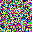

In [39]:
to_img(s)